# Model Development

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV

## Data Preparation

In [23]:
# Replace with the path to Chicago dataset
chicago_filepath = "Chicago_after_FE.csv"
# Replace with the path to NIBRS test dataset
NIBRS_filepath = "NIBRS_after_FE.csv"

# Read the dataset
chicago_df = pd.read_csv(chicago_filepath)
NIBRS_df = pd.read_csv(NIBRS_filepath)

/var/folders/gv/4cnh8blj2mgcj1tbxqms_3yw0000gn/T/ipykernel_60181/3116578832.py:8: DtypeWarning: Columns (8,9,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  NIBRS_df = pd.read_csv(NIBRS_filepath)


In [25]:
# Check Date Range
c_min_date = chicago_df['date'].min()
c_max_date = chicago_df['date'].max()
n_min_date = NIBRS_df['date'].min()
n_max_date = NIBRS_df['date'].max()
print(f"Chicago Dataset Date Range: {c_min_date} to {c_max_date}")
print(f"NIBRS Dataset Date Range: {n_min_date} to {n_max_date}")

Chicago Dataset Date Range: 2020-07-31 17:29:00 to 2025-03-16 03:00:00
NIBRS Dataset Date Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00


In [ ]:
chicago_df['date'] = pd.to_datetime(chicago_df['date'])
# Choose data from 2021-01-01 to 2022-12-31 for model training and initial testing
filtered_df = chicago_df[(chicago_df['date'] >= '2021-01-01') & (chicago_df['date'] <= '2022-12-31')]

print(f"Chicago Dataset Date Range After Filtering: {filtered_df['date'].min()}, {filtered_df['date'].max()}")

Chicago Dataset Date Range After Filtering: 2021-01-01 00:00:00, 2022-12-31 00:00:00


In [27]:
chicago_df = filtered_df
print("Chicago dataset shape:", chicago_df.shape)

Chicago dataset shape: (448489, 32)


In [28]:
NIBRS_df.shape

(562976, 37)

In [29]:
feature_columns = [
    'arrest', 'UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday', 
    'is_weekend', 'is_holiday', 'crime_against', 'offense_category_name'
]

chicago_df = chicago_df[feature_columns]

In [30]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [73]:
X = chicago_df.drop(columns=['arrest']) 
y = chicago_df['arrest']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [75]:
y_test.isna().sum()

0

## Model Training

## CatBoost Model:
- Handles categorical data well: CatBoost is great at working with categorical features **without needing much preprocessing**, which saves time and effort.
- Reduces overfitting: It has built-in tools to prevent overfitting, making predictions more reliable, especially with complex datasets like crime data.
- Strong performance: It often outperforms other models like decision trees or random forests, giving you accurate arrest predictions.

In [77]:
y_train.value_counts()

arrest
False    315072
True      43719
Name: count, dtype: int64

For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

`Catboost` can handle this with set `scale_pos_weight`  = # of False/ # of True.

In [78]:
arrest_weight = int(y_train.value_counts()[0] / y_train.value_counts()[1])
arrest_weight

7

In [79]:
# indicate categorical features
cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    scale_pos_weight=arrest_weight,  # improve the importance of Arrest=True
    early_stopping_rounds=50,
    eval_metric='F1',  # better evaluation metric for imbalanced data
    verbose=100,
    random_state=42
)
# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)
# Predict
y_pred = model.predict(X_test)

# Evaluate the model
print("Chicago Classification Report:\n", classification_report(y_test, y_pred))

0:	learn: 0.6910929	test: 0.6915118	best: 0.6915118 (0)	total: 269ms	remaining: 4m 28s
100:	learn: 0.7425227	test: 0.7418607	best: 0.7432042 (52)	total: 7.41s	remaining: 1m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7432041643
bestIteration = 52

Shrink model to first 53 iterations.
Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.81      0.88     78768
        True       0.34      0.71      0.46     10930

    accuracy                           0.80     89698
   macro avg       0.65      0.76      0.67     89698
weighted avg       0.88      0.80      0.83     89698



### Optimize Parameters
TODO: with my local limited computational resources, it's hard to train :(

In [ ]:
# param_dist = {
#     'depth': [4, 6],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [arrest_weight, arrest_weight * 1.5],
#     'border_count': [32, 64]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='f1',
#     cv=2,
#     verbose=1,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best Params:", random_search.best_params_)

## Test Model In NIBRS

In [56]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [57]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [58]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest']) 
y_NIBRS_test = NIBRS_df['arrest']

In [59]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.83      0.86    467171
        True       0.38      0.52      0.44     95805

    accuracy                           0.78    562976
   macro avg       0.64      0.67      0.65    562976
weighted avg       0.81      0.78      0.79    562976



# Model Evaluation

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Standard Classification Metrics

In [60]:
print("Chicago Classification Report:\n", classification_report(y_test, y_pred))
print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.85      0.89    191520
        True       0.39      0.66      0.49     28480

    accuracy                           0.82    220000
   macro avg       0.67      0.76      0.69    220000
weighted avg       0.87      0.82      0.84    220000

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.83      0.86    467171
        True       0.38      0.52      0.44     95805

    accuracy                           0.78    562976
   macro avg       0.64      0.67      0.65    562976
weighted avg       0.81      0.78      0.79    562976



In [67]:
# calculate ROC AUC score
# for Chicago test set
y_proba = model.predict_proba(X_test)[:, 1]
c_auc_score = roc_auc_score(y_test, y_proba)
print("Chicago ROC-AUC Score:", c_auc_score)

# for NIBRS test set
y_NIBRS_proba = model.predict_proba(X_NIBRS_test)[:, 1]
n_auc_score = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)
print("NIBRS ROC-AUC Score:", n_auc_score)

Chicago ROC-AUC Score: 0.8494973957783327
NIBRS ROC-AUC Score: 0.7690121827074


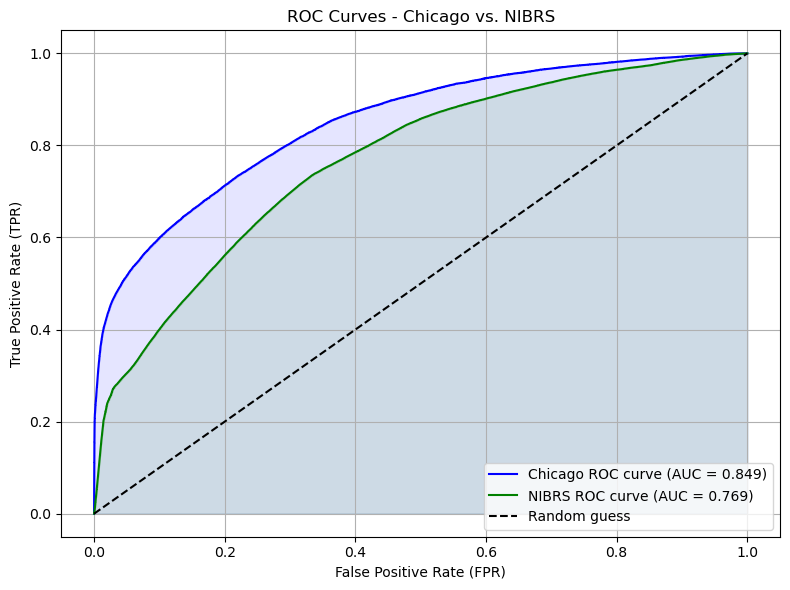

In [69]:
# Plot ROC Curves
fpr_c, tpr_c, _ = roc_curve(y_test, y_proba)
auc_c = roc_auc_score(y_test, y_proba)
fpr_n, tpr_n, _ = roc_curve(y_NIBRS_test, y_NIBRS_proba)
auc_n = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, label=f'Chicago ROC curve (AUC = {auc_c:.3f})', color='blue')
plt.plot(fpr_n, tpr_n, label=f'NIBRS ROC curve (AUC = {auc_n:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.fill_between(fpr_c, tpr_c, alpha=0.1, color='blue')
plt.fill_between(fpr_n, tpr_n, alpha=0.1, color='green')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves - Chicago vs. NIBRS')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Temporal Accuracy Measures

In [94]:
def concat_eval_df(X_test, y_test, y_pred):
    eval_df = X_test.reset_index(drop=True).copy()

    eval_df['y_true'] = pd.Series(y_test).reset_index(drop=True)
    eval_df['y_pred'] = pd.Series(y_pred).reset_index(drop=True)

    return eval_df

In [95]:
# Create evaluation DataFrame for Chicago test set
eval_df_chicago = concat_eval_df(X_test, y_test, y_pred)

# Create evaluation DataFrame for NIBRS test set
eval_df_NIBRS = concat_eval_df(X_NIBRS_test, y_NIBRS_test, y_NIBRS_pred)

In [ ]:
eval_df_chicago.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,1,1,19,21,3,0,0,Person,Assault Offenses,True,True
1,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property,True,False
2,1,4,13,13,3,0,0,Person,Assault Offenses,True,False
3,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses,True,True
4,1,5,20,15,5,1,0,Person,Assault Offenses,True,False


In [97]:
eval_df_NIBRS.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,1,1,19,21,3,0,0,Person,Assault Offenses,True,True
1,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property,True,False
2,1,4,13,13,3,0,0,Person,Assault Offenses,True,False
3,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses,True,True
4,1,5,20,15,5,1,0,Person,Assault Offenses,True,False


In [91]:
def evaluate_temporal_performance(df, group_col, y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index()

    return grouped_perf

### Evaluate Performance in Hour

In [ ]:
# Evaluate performance in Hour for Chicago test set
hourly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='hour')
print("Performance in Hour for Chicago test set: \n", hourly_perf_chicago)
# Evaluate performance in Hour for NIBRS test set
hourly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='hour')
print("Performance in Hour for NIBRS test set: \n", hourly_perf_NIBRS)

performance in Hour for Chicago test set: 
     hour  accuracy  f1_score  precision    recall   count
0      0  0.758414  0.382445   0.250914  0.803807  7339.0
1      1  0.637646  0.366045   0.235476  0.821622  2906.0
2      2  0.638074  0.331015   0.210619  0.772727  2658.0
3      3  0.644191  0.270775   0.163657  0.783784  2195.0
4      4  0.678102  0.288243   0.178404  0.750000  1749.0
5      5  0.704485  0.275081   0.172414  0.680000  1516.0
6      6  0.785714  0.291139   0.193820  0.584746  1568.0
7      7  0.820429  0.365733   0.271394  0.560606  2144.0
8      8  0.818062  0.349882   0.260563  0.532374  3023.0
9      9  0.848375  0.443182   0.348733  0.607792  3878.0
10    10  0.858809  0.566537   0.481481  0.688091  3945.0
11    11  0.864706  0.622951   0.570496  0.686028  3910.0
12    12  0.880183  0.556890   0.481074  0.661074  5233.0
13    13  0.860730  0.544892   0.473118  0.642336  4222.0
14    14  0.872340  0.551261   0.476052  0.654691  4183.0
15    15  0.874101  0.497041

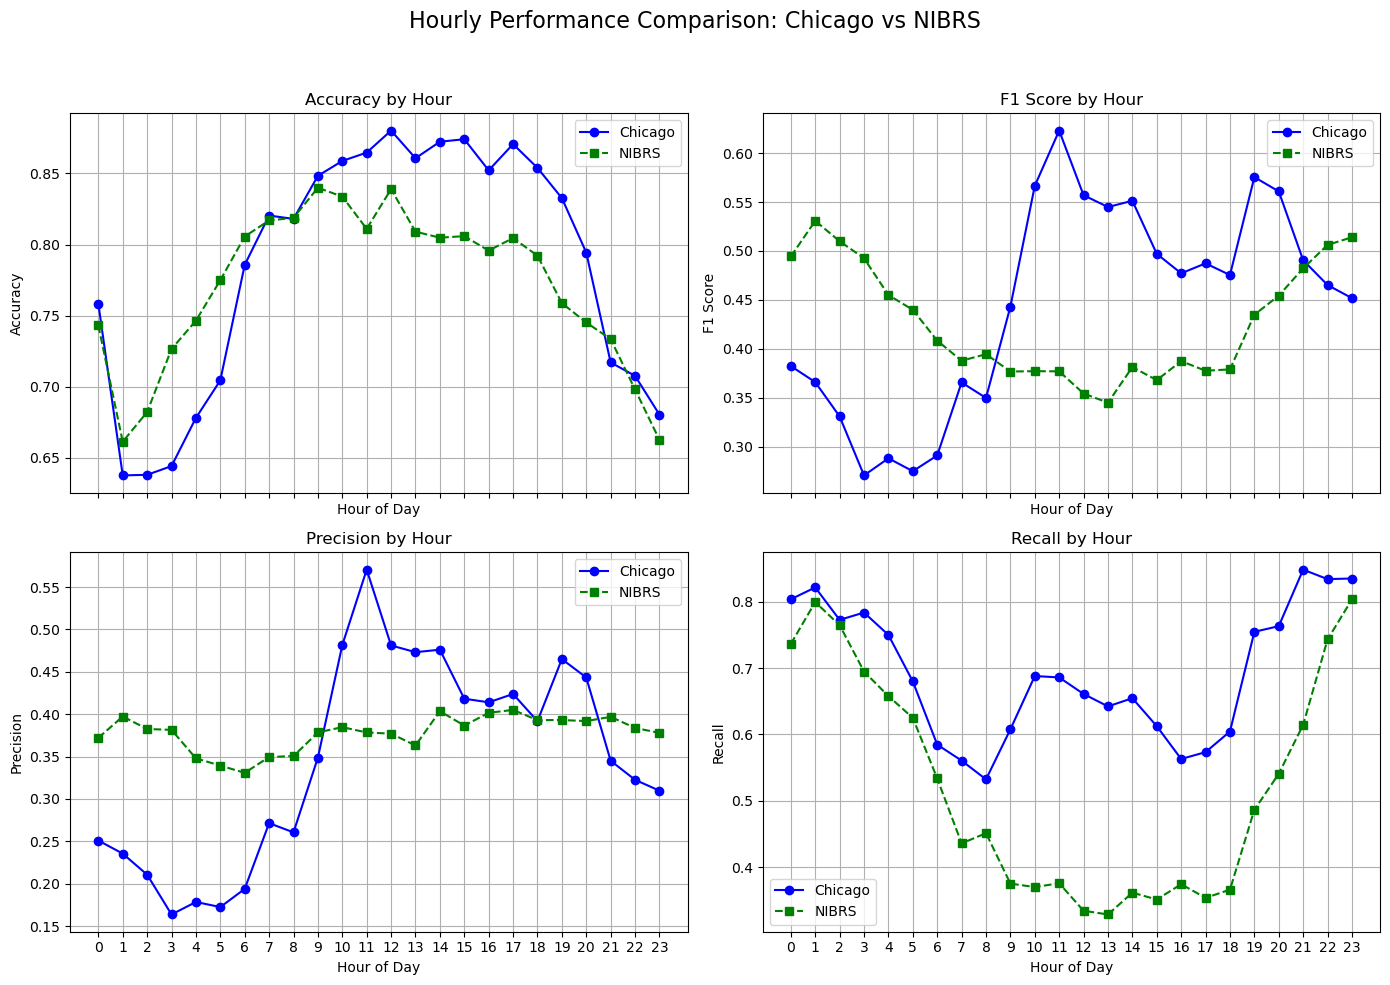

In [100]:
hourly_perf_chicago = hourly_perf_chicago.sort_values(by='hour')
hourly_perf_NIBRS = hourly_perf_NIBRS.sort_values(by='hour')

hours = hourly_perf_chicago['hour']

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

metrics = ['accuracy', 'f1_score', 'precision', 'recall']
titles = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    row = i // 2
    col = i % 2
    ax = axs[row][col]

    ax.plot(hours, hourly_perf_chicago[metric], marker='o', label='Chicago', color='blue')
    ax.plot(hours, hourly_perf_NIBRS[metric], marker='s', label='NIBRS', color='green', linestyle='--')

    ax.set_title(f'{titles[i]} by Hour', fontsize=12)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel(titles[i])
    ax.grid(True)
    ax.legend()

    ax.set_xticks(range(24))

plt.suptitle('Hourly Performance Comparison: Chicago vs NIBRS', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()